**Importing of Libraries**

In [1]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

**Loading of the dataset and Preprocessing of data**

In [2]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

**Downloading of the dataset to be used**

In [3]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset'
od.download(dataset_url) # {"username":"jjgggg","key":"dd2bf9a60631eb54931473f3e45347b4"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jjgggg
Your Kaggle Key: ··········


100%|██████████| 1.44G/1.44G [00:27<00:00, 55.2MB/s]


In [4]:
images = load_images('/content/another-anime-face-dataset')

**Displaying of the dataset**

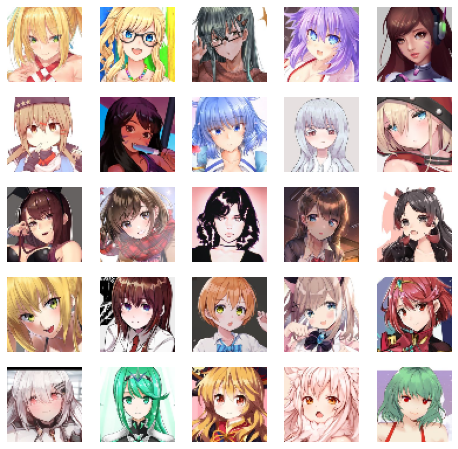

In [5]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

**Creating the GAN model**

In [6]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("Generated_Anime/Faces_%d.png" % epoch)
        plt.close()

**Training and Generating of the Anime Face**

In [7]:
#This folder will contain the images generated during the training
!mkdir Generated_Anime

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

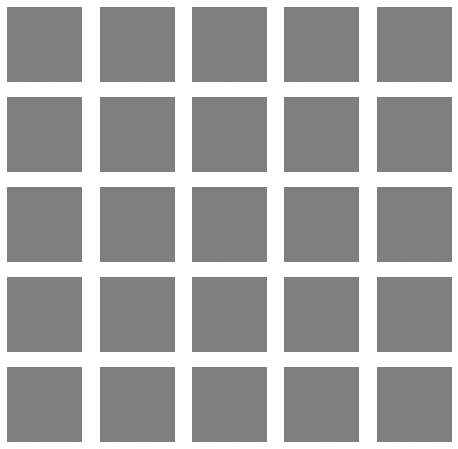

4/4 [==============================] - 0s 18ms/step
200 [Discriminator loss: 0.659012, acc.: 64.48%] [Generator loss: 1.303328]
4/4 [==============================] - 0s 18ms/step
400 [Discriminator loss: 0.620616, acc.: 66.51%] [Generator loss: 1.237416]
4/4 [==============================] - 0s 18ms/step
600 [Discriminator loss: 0.673738, acc.: 59.85%] [Generator loss: 1.119542]
4/4 [==============================] - 0s 18ms/step
800 [Discriminator loss: 0.666391, acc.: 59.38%] [Generator loss: 1.058052]
4/4 [==============================] - 0s 18ms/step
1000 [Discriminator loss: 0.600680, acc.: 67.45%] [Generator loss: 1.274487]
1/1 [==============================] - 0s 18ms/step


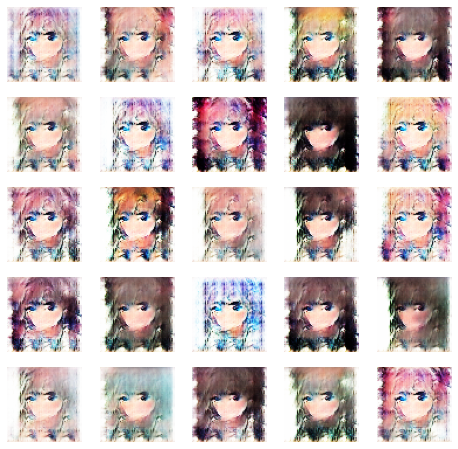

4/4 [==============================] - 0s 18ms/step
1200 [Discriminator loss: 0.596628, acc.: 68.28%] [Generator loss: 1.369189]
4/4 [==============================] - 0s 19ms/step
1400 [Discriminator loss: 0.539140, acc.: 73.08%] [Generator loss: 1.416099]
4/4 [==============================] - 0s 19ms/step
1600 [Discriminator loss: 0.591759, acc.: 68.13%] [Generator loss: 1.364567]
4/4 [==============================] - 0s 18ms/step
1800 [Discriminator loss: 0.566225, acc.: 70.46%] [Generator loss: 1.357412]
4/4 [==============================] - 0s 18ms/step
2000 [Discriminator loss: 0.556534, acc.: 71.15%] [Generator loss: 1.384334]
1/1 [==============================] - 0s 15ms/step


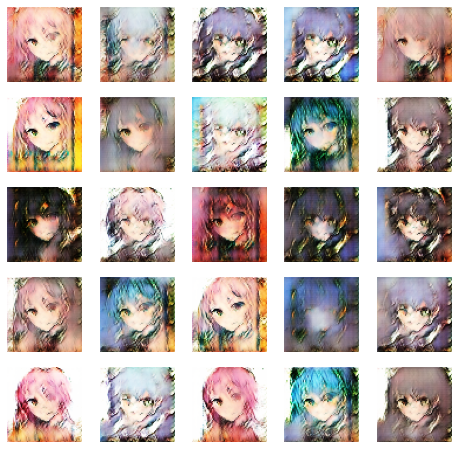

4/4 [==============================] - 0s 18ms/step
2200 [Discriminator loss: 0.510991, acc.: 74.74%] [Generator loss: 1.371250]
4/4 [==============================] - 0s 19ms/step
2400 [Discriminator loss: 0.486848, acc.: 76.82%] [Generator loss: 1.360101]
4/4 [==============================] - 0s 19ms/step
2600 [Discriminator loss: 0.542688, acc.: 72.76%] [Generator loss: 1.291368]
4/4 [==============================] - 0s 18ms/step
2800 [Discriminator loss: 0.548777, acc.: 72.46%] [Generator loss: 1.221049]
4/4 [==============================] - 0s 18ms/step
3000 [Discriminator loss: 0.541438, acc.: 73.72%] [Generator loss: 1.150347]
1/1 [==============================] - 0s 16ms/step


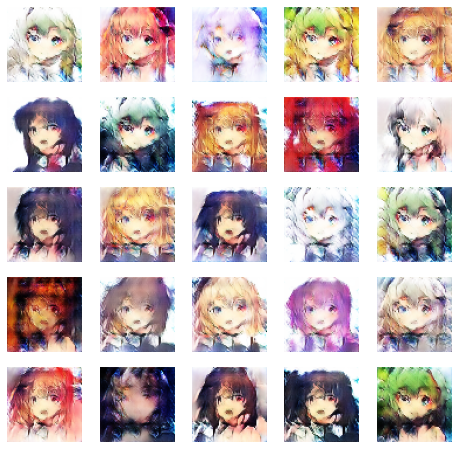

4/4 [==============================] - 0s 18ms/step
3200 [Discriminator loss: 0.542977, acc.: 72.87%] [Generator loss: 1.171754]
4/4 [==============================] - 0s 18ms/step
3400 [Discriminator loss: 0.562938, acc.: 71.04%] [Generator loss: 1.336286]
4/4 [==============================] - 0s 20ms/step
3600 [Discriminator loss: 0.538914, acc.: 73.23%] [Generator loss: 1.238879]
4/4 [==============================] - 0s 18ms/step
3800 [Discriminator loss: 0.565778, acc.: 70.84%] [Generator loss: 1.356621]
4/4 [==============================] - 0s 18ms/step
4000 [Discriminator loss: 0.577525, acc.: 69.32%] [Generator loss: 1.309778]
1/1 [==============================] - 0s 22ms/step


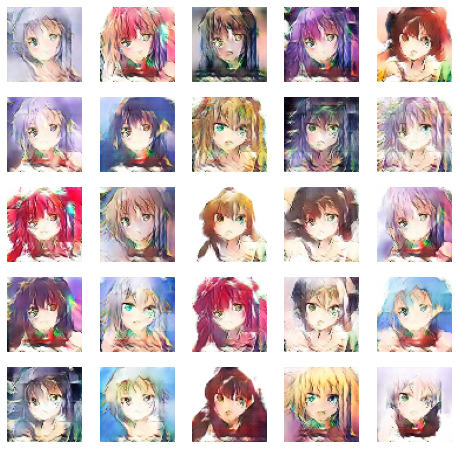

4/4 [==============================] - 0s 18ms/step
4200 [Discriminator loss: 0.561980, acc.: 70.69%] [Generator loss: 1.303082]
4/4 [==============================] - 0s 18ms/step
4400 [Discriminator loss: 0.556738, acc.: 71.48%] [Generator loss: 1.299599]
4/4 [==============================] - 0s 20ms/step
4600 [Discriminator loss: 0.564594, acc.: 70.73%] [Generator loss: 1.408220]
4/4 [==============================] - 0s 18ms/step
4800 [Discriminator loss: 0.561966, acc.: 70.73%] [Generator loss: 1.386100]
4/4 [==============================] - 0s 18ms/step
5000 [Discriminator loss: 0.562326, acc.: 70.94%] [Generator loss: 1.424783]
1/1 [==============================] - 0s 16ms/step


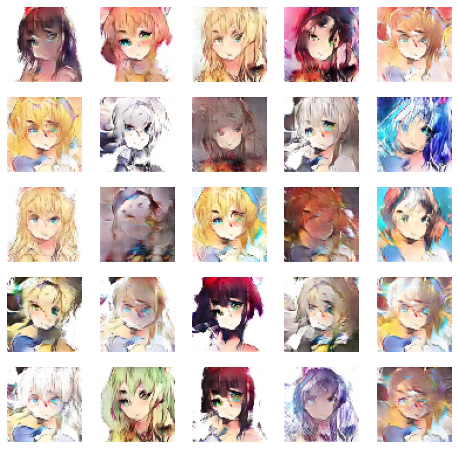

4/4 [==============================] - 0s 18ms/step
5200 [Discriminator loss: 0.552830, acc.: 71.42%] [Generator loss: 1.372115]
4/4 [==============================] - 0s 19ms/step
5400 [Discriminator loss: 0.562557, acc.: 70.46%] [Generator loss: 1.513340]
4/4 [==============================] - 0s 19ms/step
5600 [Discriminator loss: 0.549883, acc.: 71.71%] [Generator loss: 1.602797]
4/4 [==============================] - 0s 18ms/step
5800 [Discriminator loss: 0.549111, acc.: 71.59%] [Generator loss: 1.618242]
4/4 [==============================] - 0s 20ms/step
6000 [Discriminator loss: 0.534986, acc.: 72.98%] [Generator loss: 1.687882]
1/1 [==============================] - 0s 17ms/step


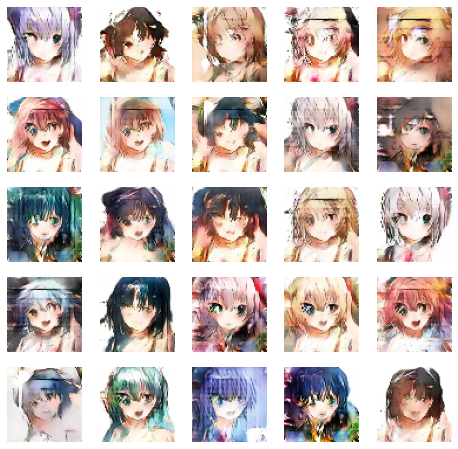

4/4 [==============================] - 0s 18ms/step
6200 [Discriminator loss: 0.528080, acc.: 73.39%] [Generator loss: 1.581540]
4/4 [==============================] - 0s 19ms/step
6400 [Discriminator loss: 0.548794, acc.: 71.65%] [Generator loss: 1.643706]
4/4 [==============================] - 0s 19ms/step
6600 [Discriminator loss: 0.536492, acc.: 72.76%] [Generator loss: 1.712169]
4/4 [==============================] - 0s 20ms/step
6800 [Discriminator loss: 0.527995, acc.: 73.24%] [Generator loss: 1.712508]
4/4 [==============================] - 0s 19ms/step
7000 [Discriminator loss: 0.524657, acc.: 73.37%] [Generator loss: 1.781694]
1/1 [==============================] - 0s 17ms/step


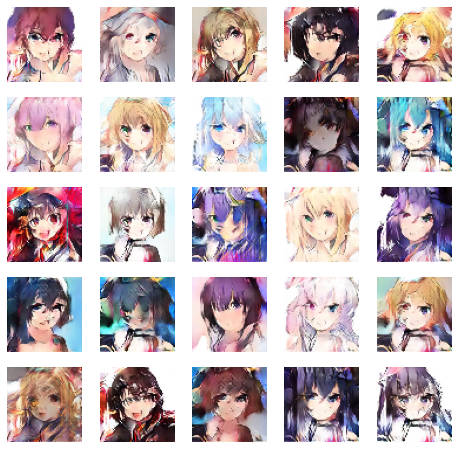

4/4 [==============================] - 0s 19ms/step
7200 [Discriminator loss: 0.521140, acc.: 73.60%] [Generator loss: 1.810317]
4/4 [==============================] - 0s 19ms/step
7400 [Discriminator loss: 0.517218, acc.: 74.17%] [Generator loss: 1.806679]
4/4 [==============================] - 0s 19ms/step
7600 [Discriminator loss: 0.498657, acc.: 75.24%] [Generator loss: 1.940782]
4/4 [==============================] - 0s 18ms/step
7800 [Discriminator loss: 0.501990, acc.: 75.22%] [Generator loss: 1.927724]
4/4 [==============================] - 0s 20ms/step
8000 [Discriminator loss: 0.488257, acc.: 75.89%] [Generator loss: 2.071867]
1/1 [==============================] - 0s 18ms/step


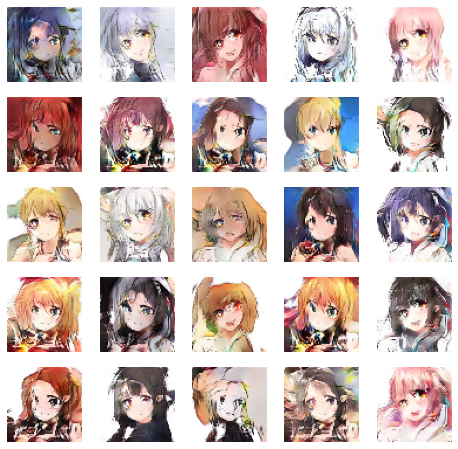

4/4 [==============================] - 0s 21ms/step
8200 [Discriminator loss: 0.489456, acc.: 76.30%] [Generator loss: 1.906866]
4/4 [==============================] - 0s 19ms/step
8400 [Discriminator loss: 0.495195, acc.: 75.33%] [Generator loss: 2.026497]
4/4 [==============================] - 0s 19ms/step
8600 [Discriminator loss: 0.477276, acc.: 76.61%] [Generator loss: 2.013924]
4/4 [==============================] - 0s 21ms/step
8800 [Discriminator loss: 0.500939, acc.: 74.94%] [Generator loss: 2.048204]
4/4 [==============================] - 0s 19ms/step
9000 [Discriminator loss: 0.481456, acc.: 76.31%] [Generator loss: 2.112323]
1/1 [==============================] - 0s 20ms/step


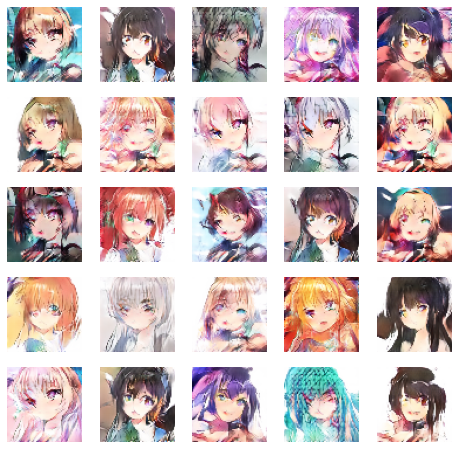

In [8]:
gan=GAN()
gan.train(epochs=10001, batch_size=256, metrics_update=200, save_images=1000, save_model=10000)

**Showing of the Generated Anime Face**

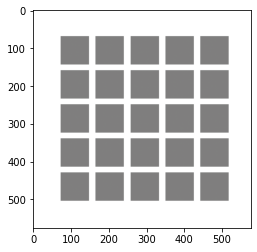

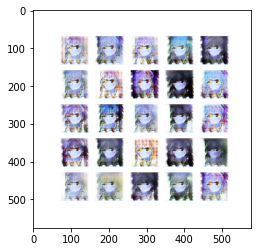

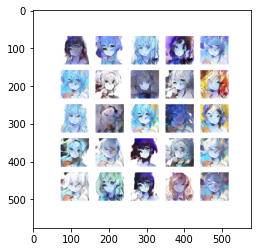

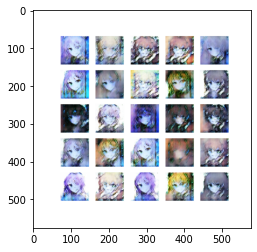

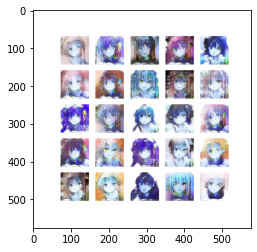

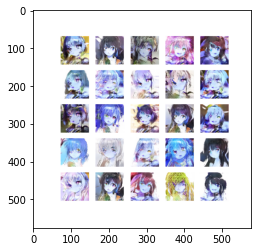

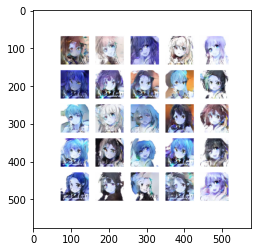

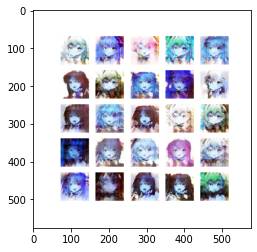

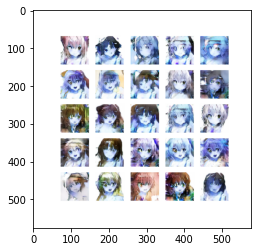

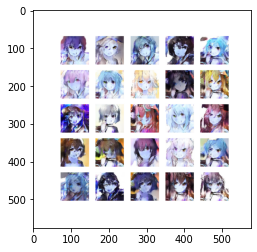

In [11]:
imdir = '/content/Generated_Anime'
ext = ['png', 'jpg', 'jpeg']    # Add image formats here
images = os.listdir(imdir)

for img in images: 
  img_arr = cv2.imread(os.path.join(imdir,img))
  plt.figure()
  plt.imshow(img_arr)

Don Gabriel L. So